In [28]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geopy.distance

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


**Download aussie postcode data**

In [29]:
!wget -q -O 'aussie_postcode.json' https://raw.githubusercontent.com/Elkfox/Australian-Postcode-Data/master/au_postcodes.json
    #https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('aussie_postcode.json') as json_data:
    aussie_postcode = json.load(json_data)

Data downloaded!


**We would limit only regions within 10km from Adelaide**
<br>**Identify postcode and state code as PCSTATE**


In [30]:
neighborhoods_data = aussie_postcode

# define the dataframe columns
column_names = ['PostCode', 'Place', 'StateCode', 'StateName','Longitude', 'Latitude','KMFromCBD'] 

# instantiate the dataframe
adelaide = pd.DataFrame(columns=column_names)


coords1=(-34.9287,138.5986)

for data in neighborhoods_data:
    postcode = neighborhood_name = data['postcode']
    place = data['place_name']
    statecode=data['state_code']    
    statename=data['state_name']   
    longitude = data['longitude']  
    latitude = data['latitude']  
    KMFromCBD=geopy.distance.vincenty(coords1, (latitude,longitude)).km
  
    
    adelaide = adelaide.append({'PostCode': postcode,
                                          'Place': place,
                                          'StateCode': statecode,
                                          'StateName': statename,
                                          'Longitude': longitude,
                                          'Latitude': latitude,
                                          'KMFromCBD': KMFromCBD}, ignore_index=True)

    
adelaide = adelaide[adelaide.KMFromCBD <= 10]    
adelaide["rank"] = adelaide.groupby(['PostCode'])['KMFromCBD'].rank(method='first',ascending=True)
adelaide.PostCode = adelaide.PostCode.astype(str)
adelaide['PCState'] = adelaide[['PostCode', 'StateCode']].apply(lambda x: ' - '.join(x), axis=1)
#neighborhoods = neighborhoods[neighborhoods.rank == 1]    
adelaide=adelaide.loc[adelaide['rank'] == 1]
adelaide = adelaide[['PCState','Longitude','Latitude']]
#adelaide.head()

#LET's do the same with Melbourne data
coords2=(-37.814000,144.9633200)
melbourne = pd.DataFrame(columns=column_names)


for data in neighborhoods_data:
    postcode = neighborhood_name = data['postcode']
    place = data['place_name']
    statecode=data['state_code']    
    statename=data['state_name']   
    longitude = data['longitude']  
    latitude = data['latitude']  
    KMFromCBD=geopy.distance.vincenty(coords2, (latitude,longitude)).km
  
    
    melbourne = melbourne.append({'PostCode': postcode,
                                          'Place': place,
                                          'StateCode': statecode,
                                          'StateName': statename,
                                          'Longitude': longitude,
                                          'Latitude': latitude,
                                          'KMFromCBD': KMFromCBD}, ignore_index=True)

    
melbourne = melbourne[melbourne.KMFromCBD <= 10]    
melbourne["rank"] = melbourne.groupby(['PostCode'])['KMFromCBD'].rank(method='first',ascending=True)
melbourne.PostCode = melbourne.PostCode.astype(str)
melbourne['PCState'] = melbourne[['PostCode', 'StateCode']].apply(lambda x: ' - '.join(x), axis=1)
#neighborhoods = neighborhoods[neighborhoods.rank == 1]    
melbourne=melbourne.loc[melbourne['rank'] == 1]
melbourne = melbourne[['PCState','Longitude','Latitude']]



**Merge two data frames**

In [31]:
neighborhoods = adelaide.append(melbourne, ignore_index=True)
neighborhoods.shape

(213, 3)

**GET ALL VENUES DETAIL AND CATEGORY WHICH SURROUNDS PCSTATE(POSTCODE AND STATE)**

*1. Accessing four square API database*

In [32]:
CLIENT_ID = '1UAM34UX4YLZQ2RMVO41SB5WWH5GOZJ5JF3HPZ4TDTTLXEUG' # your Foursquare ID
CLIENT_SECRET = '3CB2XHWXIRMTLTXWID4MADTZ5JN5S2ABFEGO10BK3M4KDC3H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods.loc[0, 'PCState'] # neighborhood name

*2. Limit FourSquare to return max 100 venues within 500m radius*

In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=1UAM34UX4YLZQ2RMVO41SB5WWH5GOZJ5JF3HPZ4TDTTLXEUG&client_secret=3CB2XHWXIRMTLTXWID4MADTZ5JN5S2ABFEGO10BK3M4KDC3H&v=20180605&ll=-34.9287,138.5986&radius=500&limit=100'

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',           
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
AdelaideMelbourne_venues = getNearbyVenues(names=neighborhoods['PCState'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



5000 - SA
5001 - SA
5005 - SA
5006 - SA
5007 - SA
5008 - SA
5009 - SA
5010 - SA
5011 - SA
5012 - SA
5013 - SA
5014 - SA
5022 - SA
5023 - SA
5024 - SA
5025 - SA
5031 - SA
5032 - SA
5033 - SA
5034 - SA
5035 - SA
5037 - SA
5038 - SA
5039 - SA
5040 - SA
5041 - SA
5042 - SA
5043 - SA
5044 - SA
5045 - SA
5046 - SA
5052 - SA
5061 - SA
5062 - SA
5063 - SA
5064 - SA
5065 - SA
5066 - SA
5067 - SA
5068 - SA
5069 - SA
5070 - SA
5071 - SA
5072 - SA
5073 - SA
5074 - SA
5075 - SA
5081 - SA
5082 - SA
5083 - SA
5084 - SA
5085 - SA
5086 - SA
5087 - SA
5094 - SA
5140 - SA
5141 - SA
5150 - SA
5632 - SA
5800 - SA
5810 - SA
5839 - SA
5860 - SA
5861 - SA
5862 - SA
5863 - SA
5864 - SA
5865 - SA
5866 - SA
5867 - SA
5868 - SA
5869 - SA
5870 - SA
5871 - SA
5872 - SA
5873 - SA
5874 - SA
5875 - SA
5876 - SA
5877 - SA
5878 - SA
5879 - SA
5880 - SA
5881 - SA
5882 - SA
5883 - SA
5884 - SA
5885 - SA
5886 - SA
5887 - SA
5888 - SA
5889 - SA
5890 - SA
5891 - SA
5892 - SA
5893 - SA
5894 - SA
5895 - SA
5896 - SA
5897 - SA


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

*3. Display venues in selected areas in Adelaide and Melbourne (each <10km from CBD)*

In [16]:
AdelaideMelbourne_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,5000 - SA,-34.9287,138.5986,4b4566d4f964a520140c26e3,Adelaide Central Market,-34.929479,138.597674,Farmers Market
1,5000 - SA,-34.9287,138.5986,4b4fcab5f964a520901527e3,Sushi Train,-34.930260,138.597853,Sushi Restaurant
2,5000 - SA,-34.9287,138.5986,4b56be15f964a5200c1a28e3,La Boheme,-34.928673,138.597654,Wine Bar
3,5000 - SA,-34.9287,138.5986,4cfd589c0df3236a3e9603aa,Blefari Caffe & Cucina,-34.927201,138.600413,Café
4,5000 - SA,-34.9287,138.5986,4ecf22bccc219860f5f088c3,Chatime,-34.928814,138.596546,Tea Room


*4. Find top 5 most common venues in selected areas in Adelaide and Melbourne (each <10km from CBD)*

In [42]:
# one hot encoding
AdelaideMelbourne_onehot = pd.get_dummies(AdelaideMelbourne_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
AdelaideMelbourne_onehot['Neighborhood'] = AdelaideMelbourne_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [AdelaideMelbourne_onehot.columns[-1]] + list(AdelaideMelbourne_onehot.columns[:-1])
AdelaideMelbourne_onehot = AdelaideMelbourne_onehot[fixed_columns]

AdelaideMelbourne_onehot.head()

AdelaideMelbourne_grouped = AdelaideMelbourne_onehot.groupby('Neighborhood').sum().reset_index()
AdelaideMelbourne_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Terminal,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Green,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,Opera House,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Pier,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Social Club,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,University,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,3000 - VIC,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,8,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,2,0,0,0,0,0,0,8,0,0,2,0,0,0,0,0,3,0,0,2,4,9,0,1,1,0,0,2,0,0,0,0,0,0,0,0,4,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = AdelaideMelbourne_grouped['Neighborhood']

for ind in np.arange(AdelaideMelbourne_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(AdelaideMelbourne_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3000 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
1,3001 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
2,3002 - VIC,Café,Convenience Store,Hotel,Breakfast Spot,Thai Restaurant
3,3003 - VIC,Café,Pub,Hotel,Indian Restaurant,Park
4,3004 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop


**UNSUPERVISED LEARNING = K-MEANS CLUSTERING TO GROUP SIMILAR NEIGHBORHOODS BETWEEN SA(ADELAIDE) AND VIC (MELBOURNE)**

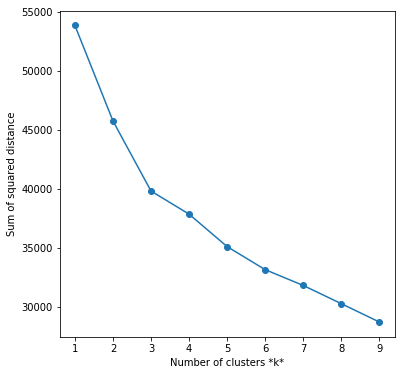

In [57]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

AdelaideMelbourne_grouped_clustering = AdelaideMelbourne_grouped.drop('Neighborhood', 1)

# Standarize features
scaler = StandardScaler()
AdelaideMelbourne_grouped_clustering_std = scaler.fit_transform(AdelaideMelbourne_grouped_clustering)
AdelaideMelbourne_grouped_clustering_std
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(AdelaideMelbourne_grouped_clustering_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.show()

In [60]:
# set number of clusters
kclusters = 3


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(AdelaideMelbourne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

AdelaideMelbourne_merged = neighborhoods
AdelaideMelbourne_merged.columns=['Neighborhood','Longitude','Latitude']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
AdelaideMelbourne_merged = AdelaideMelbourne_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

AdelaideMelbourne_merged.head() # check the last columns!

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,5000 - SA,138.5986,-34.9287,1.0,Café,Coffee Shop,Asian Restaurant,Bar,Gym
1,5001 - SA,138.5986,-34.9287,1.0,Café,Coffee Shop,Asian Restaurant,Bar,Gym
2,5005 - SA,138.5702,-34.9006,0.0,Gym,Afghan Restaurant,Liquor Store,Bar,Burger Joint
3,5006 - SA,138.5914,-34.9073,0.0,Pub,Italian Restaurant,Café,Thai Restaurant,Burger Joint
4,5007 - SA,138.5791,-34.9026,0.0,Breakfast Spot,Café,Supermarket,Thrift / Vintage Store,Greek Restaurant


In [61]:
AdelaideMelbourne_merged.loc[AdelaideMelbourne_merged['Cluster Labels'] == 0, AdelaideMelbourne_merged.columns[[0] + list(range(4, AdelaideMelbourne_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,5005 - SA,Gym,Afghan Restaurant,Liquor Store,Bar,Burger Joint
3,5006 - SA,Pub,Italian Restaurant,Café,Thai Restaurant,Burger Joint
4,5007 - SA,Breakfast Spot,Café,Supermarket,Thrift / Vintage Store,Greek Restaurant
5,5008 - SA,Gym,Afghan Restaurant,Liquor Store,Bar,Burger Joint
6,5009 - SA,Supermarket,Pizza Place,Sushi Restaurant,Café,Liquor Store
7,5010 - SA,Vietnamese Restaurant,Pub,Golf Course,Zoo Exhibit,Farmers Market
8,5011 - SA,Pub,Vietnamese Restaurant,Video Store,Fast Food Restaurant,Electronics Store
9,5012 - SA,Vietnamese Restaurant,Gym / Fitness Center,Tanning Salon,Asian Restaurant,Fast Food Restaurant
10,5013 - SA,Café,Zoo Exhibit,Food Truck,Food & Drink Shop,Food
11,5014 - SA,Bar,Liquor Store,Athletics & Sports,Gas Station,Fast Food Restaurant


In [62]:
AdelaideMelbourne_merged.loc[AdelaideMelbourne_merged['Cluster Labels'] == 1, AdelaideMelbourne_merged.columns[[0] + list(range(4, AdelaideMelbourne_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,5000 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
1,5001 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
59,5800 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
60,5810 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
61,5839 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
62,5860 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
63,5861 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
64,5862 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
65,5863 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym
66,5864 - SA,Café,Coffee Shop,Asian Restaurant,Bar,Gym


In [63]:
AdelaideMelbourne_merged.loc[AdelaideMelbourne_merged['Cluster Labels'] == 2, AdelaideMelbourne_merged.columns[[0] + list(range(4, AdelaideMelbourne_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
111,812 - NT,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
113,3000 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
114,3001 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
117,3004 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
118,3005 - VIC,Coffee Shop,Café,Bar,Cocktail Bar,Chocolate Shop
142,3065 - VIC,Café,Bar,Vegetarian / Vegan Restaurant,Cocktail Bar,Asian Restaurant
177,8001 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
189,8045 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
190,8051 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
191,8060 - VIC,Coffee Shop,Bar,Café,Cocktail Bar,Dessert Shop
